In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, log_loss, accuracy_score, precision_score, recall_score, jaccard_score, roc_auc_score
from sklearn.model_selection import KFold

In [3]:
data = pd.read_csv('term-deposit-marketing-2020.csv')

## Preprocessing

* label encoding
* one hot encoding
* scaling

In [4]:
x = data[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign']]
y = data[['y']]

le = LabelEncoder()
mms = MinMaxScaler()
ohe = OneHotEncoder()

y_enc = le.fit_transform(y.values.ravel())

numeric_features = x.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x.select_dtypes(include=['object']).columns

x_num = x[numeric_features]
x_cat = x[categorical_features]
x_num_scaled = mms.fit_transform(x_num)
x_cat_encoded = ohe.fit_transform(x_cat)

categporic_df = pd.DataFrame(data=x_cat_encoded.toarray(), columns=ohe.get_feature_names())
numeric_df = pd.DataFrame(data=x_num_scaled, columns=numeric_features)

x_enc = pd.concat((categporic_df, numeric_df), axis=1)

## Outlier detection with Isolation Forest

In [5]:
from sklearn.ensemble import IsolationForest
def iso_transformer(x, y):
    iso = IsolationForest(contamination=0.1)
    yhat = iso.fit_predict(x)
    mask = yhat != -1
    x_masked, y_masked = x[mask, :], y[mask]
    return x_masked, y_masked

x_final, y_final = iso_transformer(x_enc.values, y_enc)

## Training

In [6]:
classifier = RandomForestClassifier()

eval_scores = []
feature_importances = []
k = 0

kf = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kf.split(x_final):
    try:
        X_train, X_test = x_final[train_index], x_final[test_index]
        y_train, y_test = y_final[train_index], y_final[test_index]
        model = classifier.fit(X_train, y_train)
        k += 1
        eval_scores.append([k, model.score(X_train, y_train), model.score(X_test, y_test)])
        feature_importances.append(model.feature_importances_)
    except Exception as e:
        print(e)
eval_df = pd.DataFrame(data=eval_scores, columns=['k', 'training accuracy', 'test accuracy'])
eval_df.set_index('k')
eval_df

,k,training accuracy,test accuracy
0,1,0.999965,0.939306
1,2,1.000000,0.937917
2,3,1.000000,0.935556
3,4,0.999965,0.940278
4,5,1.000000,0.939167


## Feature Importances

As seen below; duration, balance, age, day and campaign are the most important features that determine if the client is subscribed to a term deposit.

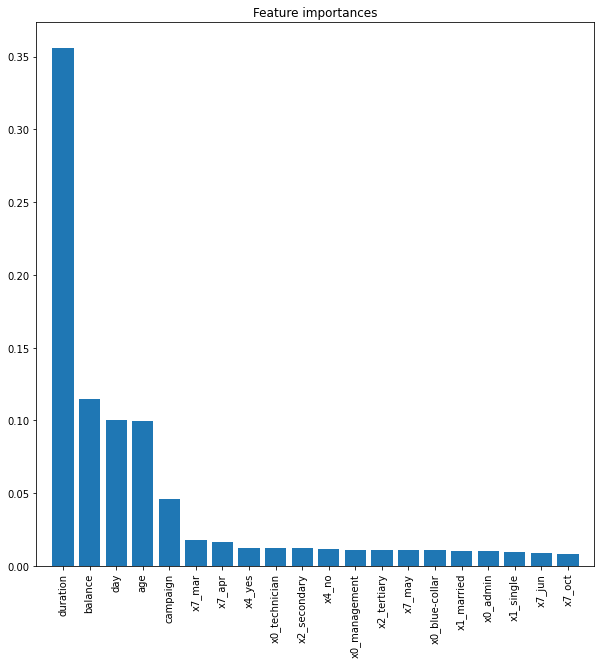

In [8]:
import matplotlib.pyplot as plt

importances = np.array(feature_importances).mean(axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.bar(x_enc.columns[indices][:20], importances[indices][:20])
plt.xticks(range(20), x_enc.columns[indices][:20], rotation=90)
plt.xlim([-1, 20])
plt.show()